# 1. Comando Iniciais

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Importando Bibliotecas

In [2]:
!pip install mlxtend --upgrade --no-deps # Versão do Mlxtend: 0.19.0

     |████████████████████████████████| 1.3 MB 6.5 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow import keras

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Utility Script - Criados dentro do Kaggle Code, devido ao fato que são modulo customizados 
%cd /content/drive/MyDrive/TCC-Melo/Kaggle/
from lrfinder import *
from cyclicallr import * 

/content/drive/MyDrive/TCC-Melo/Kaggle


### 1.1.1. Demostrando versões das bibliotecas

In [5]:
print(f'Versão do Numpy: {np.__version__}')
print(f'Versão do Pandas: {pd.__version__}')
print(f'Versão do Matplotlib: {mpl.__version__}')
print(f'Versão do Season: {sns.__version__}')
print(f'Versão do Plotly: {plotly.__version__}')
print(f'Versão do TensorFlow: {tf.__version__}')
print(f'Versão do Keras: {keras.__version__}')
print(f'Versão do Sklearn: {sklearn.__version__}')
print(f'Versão do Mlxtend: {mlxtend.__version__}')

Versão do Numpy: 1.19.5
Versão do Pandas: 1.1.5
Versão do Matplotlib: 3.2.2
Versão do Season: 0.11.2
Versão do Plotly: 4.4.1
Versão do TensorFlow: 2.6.0
Versão do Keras: 2.6.0
Versão do Sklearn: 0.22.2.post1
Versão do Mlxtend: 0.19.0


## 1.2. Verificando Accelerator

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct  3 23:22:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
tf.test.is_gpu_available()

Name: /physical_device:GPU:0   Type: GPU
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 1.3. Variaveis Globais 

In [8]:
# Caminho para salvar os melhores modelos do callback checkpoint
save_dir = '/content/drive/MyDrive/TCC-Melo/Kaggle/modelos_checkPoint/'

# Caminho dos Folds
fold_var = 1 # Folder selecionado

train_path = f'/content/drive/MyDrive/TCC-Melo/Dados/Folds_Modified/fold_{fold_var}/train_dir'    # Imagens em JPG separadas em folders
valid_path = f'/content/drive/MyDrive/TCC-Melo/Dados/Folds_Modified/fold_{fold_var}/val_dir'    # Imagens em JPG separadas em folders

# Ordem das categorias
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
#         [0      , 1    , 2    , 3   , 4    , 5   , 6]

# Tamanho da batch
batch_size = 16

# Dimensão das imagens de entrada
image_size = (448, 448)

# Numero de epochs
## Primeiro Momento:
first_epoch = 30

## Segundo Momento:
second_epoch = first_epoch + 70

# Calculando os passos para o treinamento
train_steps = np.ceil(8912 / batch_size)
val_steps = np.ceil(1103 / batch_size)

# Carregando os pesos para as categorias para o treinamento 
weights_train_dict = {0: 15, 1: 10, 2: 5, 3: 42,
                      4: 20, 5: 1, 6: 35}

## 1.4. Metricas de avaliação

In [9]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'), 
                      AUC(name='auc'),
                      Precision(name='precision'), 
                      Recall(name='recall')]

## 1.5. Carregando os dados

 ### 1.5.1. Treinamento

In [10]:
train_ds = image_dataset_from_directory(train_path,
                                        batch_size=batch_size,
                                        image_size = image_size,
                                        label_mode='categorical',
                                        shuffle=True,
                                        seed=42)

Found 8912 files belonging to 7 classes.


In [11]:
val_ds = image_dataset_from_directory(valid_path,
                                      batch_size=batch_size,
                                      image_size = image_size,
                                      label_mode='categorical',
                                      shuffle=False,
                                      seed=42)

Found 1103 files belonging to 7 classes.


#### 1.5.1.1. Alta velocidade de treinamento

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 448, 448, 3)
(16, 7)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 1.6. Modelo Pré-treinado

In [14]:
num_model = 5

### 1.6.1. Selecionando modelo

In [15]:
if num_model == 1:
    nomeDoModelo = 'DenseNet121'
    modelo = tf.keras.applications.DenseNet121(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 2:
    nomeDoModelo = 'DenseNet169'
    modelo = tf.keras.applications.DenseNet169(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 3:
    nomeDoModelo = 'DenseNet201'
    modelo = tf.keras.applications.DenseNet201(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 4:
    nomeDoModelo = 'ResNet50V2'
    modelo = tf.keras.applications.ResNet50V2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 5:
    nomeDoModelo = 'ResNet101V2'
    modelo = tf.keras.applications.ResNet101V2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 6:
    nomeDoModelo = 'ResNet152V2'
    modelo = tf.keras.applications.ResNet152V2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 7:
    nomeDoModelo = 'Xception'
    modelo = tf.keras.applications.Xception(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 8:
    nomeDoModelo = 'InceptionV3'
    modelo = tf.keras.applications.InceptionV3(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 9:
    nomeDoModelo = 'InceptionResNetV2'
    modelo = tf.keras.applications.InceptionResNetV2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 10:
    nomeDoModelo = 'EfficientNetB0'
    modelo = tf.keras.applications.EfficientNetB0(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 11:
    nomeDoModelo = 'EfficientNetB1'
    modelo = tf.keras.applications.EfficientNetB1(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 12:
    nomeDoModelo = 'EfficientNetB2'
    modelo = tf.keras.applications.EfficientNetB2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 13:
    nomeDoModelo = 'EfficientNetB3'
    modelo = tf.keras.applications.EfficientNetB3(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
    
print(f'O modelo selecionado foi {nomeDoModelo}')

171327488/171317808 [==============================] - 1s 0us/step
O modelo selecionado foi ResNet101V2


# 2. Preprocessamento

## 2.1. Camada de aumento de dados

In [16]:
camada_ad = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
  tf.keras.layers.experimental.preprocessing.RandomContrast((0.8, 1.1)),
], name='data_augmentation')

## 2.2. Camada de reescalonamento

In [17]:
if num_model in [1, 2, 3]:
    camada_reescal = tf.keras.applications.densenet.preprocess_input
elif num_model in [4, 5, 6]:
    camada_reescal = tf.keras.applications.resnet_v2.preprocess_input
elif num_model == 7:
    camada_reescal = tf.keras.applications.xception.preprocess_input
elif num_model == 8:
    camada_reescal = tf.keras.applications.inception_v3.preprocess_input
elif num_model == 9:
    camada_reescal = tf.keras.applications.inception_resnet_v2.preprocess_input
elif num_model in [10, 11, 12, 13]:
    camada_reescal = tf.keras.applications.efficientnet.preprocess_input
    
print(f'A camada selecionada foi {camada_reescal}')

A camada selecionada foi <function preprocess_input at 0x7f6df62594d0>


# 3. Classificação

## 3.1. Criando o modelo: Primeiro Momento

In [18]:
modelBase = modelo

modelBase.trainable = False # Congelando os pesos do modelo base

inputs = tf.keras.Input(shape=image_size+(3,))
x = camada_ad(inputs)
x = camada_reescal(x)
x = modelBase(x, training=False) # Deixando o modelo em modo enferência por causa das camadas BatchNormalization
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(7, activation='softmax')(x)
model = tf.keras.Model(inputs, predictions, name=nomeDoModelo)

In [19]:
model.summary()

Model: "ResNet101V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 448, 448, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 448, 448, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 448, 448, 3)       0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 14, 14, 2048)      42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              

### 3.1.1. Buscando a taxa de aprendizado: LRFinder 1

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

Finding best initial lr over 100 steps


  0%|          | 0/100 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 5.75E-03


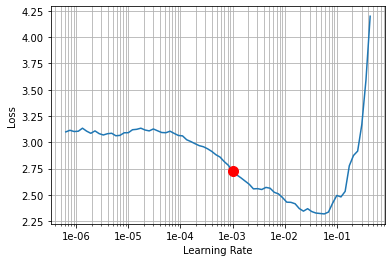

In [21]:
lr_find = LrFinder(model, optimizer, loss_fn)
lr_find.range_test(train_ds)
lr_find.plot_lrs(suggestion=True, show_grid=True)

In [22]:
base_lr = 1e-03

### 3.1.2. Treinando

In [23]:
model.compile(optimizer=Adam(learning_rate= base_lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=metricasEscolhidas)

In [24]:
history = model.fit(train_ds,
                    class_weight = weights_train_dict,
                    steps_per_epoch = train_steps,
                    epochs=first_epoch,
                    validation_data=val_ds,
                    validation_steps = val_steps)

Epoch 1/30
557/557 [==============================] - 507s 901ms/step - loss: 8.1621 - acc: 0.3519 - auc: 0.7732 - precision: 0.3963 - recall: 0.2214 - val_loss: 1.0911 - val_acc: 0.5857 - val_auc: 0.9011 - val_precision: 0.7033 - val_recall: 0.4297
Epoch 2/30
557/557 [==============================] - 108s 194ms/step - loss: 6.5779 - acc: 0.4421 - auc: 0.8327 - precision: 0.4952 - recall: 0.3340 - val_loss: 1.1366 - val_acc: 0.5675 - val_auc: 0.8919 - val_precision: 0.6404 - val_recall: 0.4343
Epoch 3/30
557/557 [==============================] - 108s 193ms/step - loss: 6.2746 - acc: 0.4698 - auc: 0.8490 - precision: 0.5187 - recall: 0.3682 - val_loss: 1.0233 - val_acc: 0.6319 - val_auc: 0.9116 - val_precision: 0.6931 - val_recall: 0.5222
Epoch 4/30
557/557 [==============================] - 108s 194ms/step - loss: 6.0713 - acc: 0.4776 - auc: 0.8554 - precision: 0.5226 - recall: 0.3812 - val_loss: 1.0563 - val_acc: 0.6074 - val_auc: 0.9066 - val_precision: 0.6578 - val_recall: 0.4932


### 3.1.3. Avaliando o treinamento do modelo

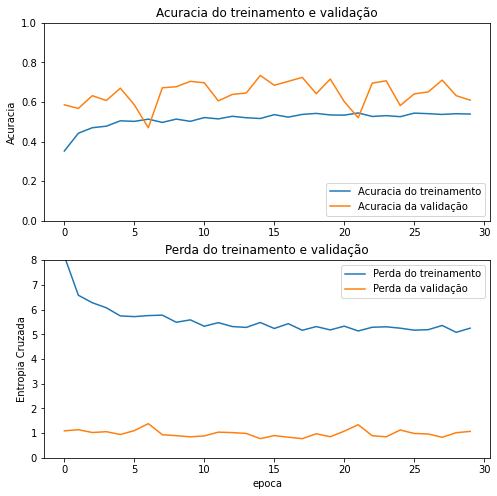

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

## 3.2. Criando o modelo: Segundo Momento

In [26]:
modelBase.trainable = True # Descongelando os pesos do modelo base para o treinamento

In [27]:
model.summary()

Model: "ResNet101V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 448, 448, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 448, 448, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 448, 448, 3)       0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 14, 14, 2048)      42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              

### 3.2.1. Buscando a taxa de aprendizado: LRFinder 2

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

Finding best initial lr over 100 steps


  0%|          | 0/100 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.20E-06


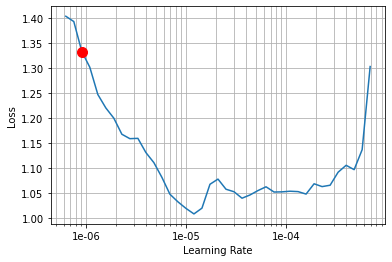

In [29]:
lr_find = LrFinder(model, optimizer, loss_fn)
lr_find.range_test(train_ds)
lr_find.plot_lrs(suggestion=True, show_grid=True)

In [30]:
base_lr = 1e-6
max_lr = 1e-5

### 3.2.2. Definindo os Callbacks

#### 3.2.2.1. CyclicalLR

In [31]:
step_size = train_steps
clr = CyclicalLR(max_lr=max_lr, 
                 base_lr=base_lr, 
                 step_size=step_size, 
                 cyclical_momentum=False)

#### 3.2.2.2. Checkpoint

In [32]:
# salva os melhores modelos para o callback
def get_model_name(k):
    return str(nomeDoModelo)+'_folder_'+ str(k)+'.h5'

In [33]:
checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var),
                                                  monitor='val_auc', verbose=1,
                                                  save_best_only=True, mode='max')

#### 3.2.2.3. Earlystopping

In [34]:
earlystopping = EarlyStopping(monitor='val_loss',
                              verbose=1, mode='min', 
                              restore_best_weights=False,
                              patience=15)

In [35]:
# Lista contendo todos os callbacks
callbacks_list = [checkpoint, earlystopping, clr]

### 3.2.3. Treinando

In [36]:
model.compile(optimizer=Adam(learning_rate=base_lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=metricasEscolhidas)

In [37]:
history_fine = model.fit(train_ds,
                    class_weight = weights_train_dict,
                    steps_per_epoch = train_steps,
                    epochs=second_epoch,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds,
                    validation_steps = val_steps,
                    callbacks = callbacks_list)

Epoch 30/100
557/557 [==============================] - 319s 555ms/step - loss: 5.0328 - acc: 0.5372 - auc: 0.8889 - precision: 0.5808 - recall: 0.4556 - val_loss: 1.0655 - val_acc: 0.5802 - val_auc: 0.9053 - val_precision: 0.6375 - val_recall: 0.4751

Epoch 00030: val_auc improved from -inf to 0.90528, saving model to /content/drive/MyDrive/TCC-Melo/Kaggle/modelos_checkPoint/ResNet101V2_folder_1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 31/100
557/557 [==============================] - 308s 552ms/step - loss: 4.3251 - acc: 0.5592 - auc: 0.9044 - precision: 0.6034 - recall: 0.4869 - val_loss: 0.7320 - val_acc: 0.7208 - val_auc: 0.9539 - val_precision: 0.7721 - val_recall: 0.6727

Epoch 00031: val_auc improved from 0.90528 to 0.95395, saving model to /content/drive/MyDrive/TCC-Melo/Kaggle/modelos_checkPoint/ResNet101V2_folder_1.h5
Epoch 32/100
557/557 [==============================] - 308s 552ms/step - loss: 3.9143 - acc: 0.5814 - auc: 0.9134 - precision: 0.6182 - recall: 0.5220 - val_loss: 1.0529 - val_acc: 0.5576 - val_auc: 0.9048 - val_precision: 0.6112 - val_recall: 0.4533

Epoch 00032: val_auc did not improve from 0.95395
Epoch 33/100
557/557 [==============================] - 308s 552ms/step - loss: 3.5477 - acc: 0.5998 - auc: 0.9204 - precision: 0.6328 - recall: 0.5424 - val_loss: 0.7341 - val_acc: 0.7416 - val_auc: 0.9537 - val_precision: 0.7706 - val_recall: 0.7035

Epoch 00033: val_auc did not improve f

### 3.2.4. Avaliando o treinamento do modelo

In [38]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

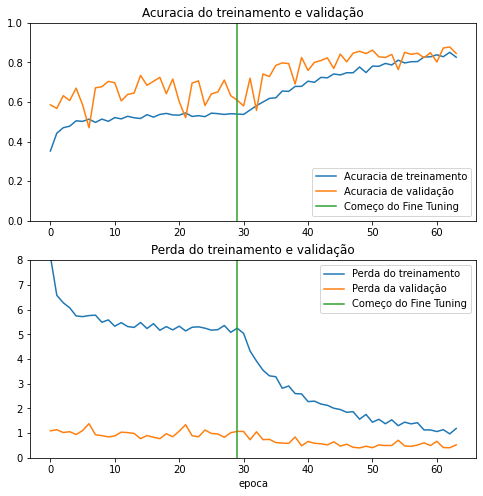

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia de treinamento')
plt.plot(val_acc, label='Acuracia de validação')
plt.ylim([0, 1])
plt.plot([first_epoch-1,first_epoch-1],
          plt.ylim(), label='Começo do Fine Tuning')
plt.legend(loc='lower right')
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.ylim([0, 8])
plt.plot([first_epoch-1,first_epoch-1],
         plt.ylim(), label='Começo do Fine Tuning')
plt.legend(loc='upper right')
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

#### 3.2.4.1. Verificando CLR

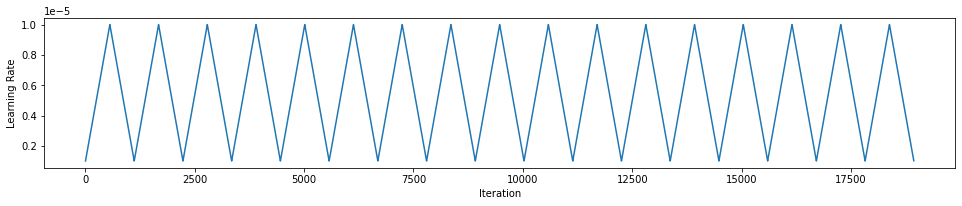

In [40]:
clr.plot_lr((14, 3.5))

# 4. Avaliando o modelo

In [41]:
model.load_weights(save_dir + str(nomeDoModelo)+'_folder_'+ str(fold_var)+'.h5')
# model_all = tf.keras.models.load_model(save_dir + str(nomeDoModelo)+'_folder_'+ str(fold_var)+'.h5')

In [42]:
model.evaluate(val_ds)

69/69 [==============================] - 12s 166ms/step - loss: 0.4002 - acc: 0.8568 - auc: 0.9852 - precision: 0.8755 - recall: 0.8413


[0.4002003073692322,
 0.8567543029785156,
 0.9851849675178528,
 0.8754717111587524,
 0.8413417935371399]

## 4.1. Realizando as previsões

In [43]:
# Obtendo a tabela verdade 
true_categories = tf.concat([y for x, y in val_ds], axis=0)
true_categories  = tf.argmax(true_categories , axis=1)

In [44]:
# Realizando as previsões
predictions = model.predict(val_ds, verbose=1)
y_pred = tf.argmax(predictions, axis=1)

69/69 [==============================] - 12s 152ms/step


## 4.3. Metricas de avaliação

### 4.3.1. Quadro de metricas

In [45]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
print(classification_report(true_categories , y_pred, target_names=cm_plot_labels))

              precision    recall  f1-score   support

       akiec       0.56      0.50      0.53        30
         bcc       0.89      0.71      0.79        35
         bkl       0.58      0.78      0.67        88
          df       0.36      0.62      0.45         8
         mel       0.34      0.83      0.48        46
          nv       0.99      0.89      0.93       883
        vasc       0.92      0.85      0.88        13

    accuracy                           0.86      1103
   macro avg       0.66      0.74      0.68      1103
weighted avg       0.91      0.86      0.87      1103



### 4.3.2. Matriz de confusão

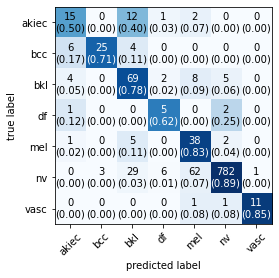

In [46]:
cm = confusion_matrix(true_categories , y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True, 
                                class_names=cm_plot_labels)

### 4.3.3. Acurácia balanceada

In [47]:
bAcc= sklearn.metrics.balanced_accuracy_score(true_categories, y_pred)
print(f'Acurácia balanceada: {bAcc*100:.6f}%')

Acurácia balanceada: 74.017638%
